# Instantiation of variables and functions

In [1]:
%%capture
%matplotlib inline
import numpy as np
import sys
import os
import itertools
import matplotlib as mt
import matplotlib.pyplot as plt
import mne
import pandas as pd
from pyprep.prep_pipeline import PrepPipeline
from joblib import Parallel, delayed
from autoreject import AutoReject
import pickle
import sklearn
import seaborn as sns
import shutil
from mne_bids import write_raw_bids, BIDSPath, print_dir_tree
from mne_bids.stats import count_events

SavingPath = r'D:\WCM_data_analysis\Theta_analysis' #to modifiy
SavingFigurePath = SavingPath + '\Figures'
Dataset = os.listdir(SavingPath)
fileComp =               []
EEG_name =               []
splitedEEGname =         []
fileExt  =               []
subject  =                ['TBI']
modality =                'epo.fif'
protocol =                'ATTN'
session  =                'S1'
network  =                'executing'
freq_bands_of_interest = ['theta','alpha']
electrodes =             ['Fz']
n_ica_components = 80
ecg_detectionThres = 0.7
resampling = 250

for file in Dataset:
    if protocol in file and modality in file and any(x in file for x in subject) and session in file:
        fileComp = os.path.splitext(file)
        EEG_name.append(fileComp[0])
        splitedEEGname.append(fileComp[0].split('_'))
        fileExt.append(fileComp[1])
 
InfoAttr = ['Subject','Protocol','Subject_#','Visit','Modality']
FilesInfo = {InfoAttr[0]:[v[0] for v in splitedEEGname],
             InfoAttr[1]:[v[1] for v in splitedEEGname],
             InfoAttr[2]:[v[2] for v in splitedEEGname],
             InfoAttr[3]:[v[3] for v in splitedEEGname],
             InfoAttr[4]:[v[-1] for v in splitedEEGname]}

#Epochs definition
epoch_tmin = -1
epoch_tmax = 2
epoch_baseline = (-0.5,0)

#Signal and modality definition
raws = list()
icas = list()
epochs = list()

#Frequency bands
freq_bands = {
    'theta': [ 4,    7],
    'alpha': [ 8,   12],
    'beta' : [12.5, 30],
    'gamma': [30,   90]}

#Events selection
if network == 'executing':
    EventsWanted = ['congruent', 'incongruent']
else:
    EventsWanted = ['no_cue', 'center', 'spatial']

############################## FUNCTIONS ##########################################


############################################################################ EXTRACTING AND ADDING ECG CHANNEL ############################################################################
# This was to try pattern matching ICA heartbeat component rejection. Because not all subject has an ECG activity recorded, the solution was to base the pattern of 
# Subject HC001 heartbeat through their existing ECG channel, and to compare to the other subject ICA by template matching. If the correlation is high (above a certain threshold) the component deteceted is considered as heartbeat
# However after review, this method was not robust across subject as the spatial pattern of the heartbeat is not consistant. So this function read the raw EGI file and add the ECG channel to the existing preprocessed raw file.
def add_ecg_channel(raw):
    raw_ecg = mne.io.read_raw_egi(r'Z:\Post_Doc\Data\LegacyData\HC_ATTN_001_S1_20180314_114923.mff',preload=True)
    sample_rate = raw_ecg.info["sfreq"]
    raw_ecg.notch_filter([60*i for i in range(1,8)],picks='ecg')
    events = mne.find_events(raw_ecg,output='onset')
    remap_event_dict = {16: 'no_cue/congruent/up',
                        15: 'no_cue/incongruent/up',
                        19: 'no_cue/congruent/dwn',
                        17: 'no_cue/incongruent/dwn',
                        20: 'center/congruent/up',
                        21: 'center/incongruent/up',
                        13: 'center/congruent/dwn',
                        14: 'center/incongruent/dwn',
                        11: 'spatial/congruent/up',
                        10: 'spatial/incongruent/up',
                        12: 'spatial/congruent/dwn',
                        18: 'spatial/incongruent/dwn',
                        9: 'CueVisible',
                        8: 'FixationStart'}
                        
    EventAnnotations = mne.annotations_from_events(events,
                                                   sfreq = sample_rate, 
                                                   event_desc=remap_event_dict,
                                                   orig_time=raw_ecg.info['meas_date'])

    raw_ecg.set_annotations(EventAnnotations)
    OnsetLastBreak = raw_ecg.annotations.onset[-1]+0.5
    StopLastBreak = raw_ecg.tmax

    LastBreakAnnot = mne.Annotations(onset=OnsetLastBreak,
                                     duration=StopLastBreak-OnsetLastBreak,
                                     description='BAD_break',
                                     orig_time=raw_ecg.info['meas_date'])

    raw_ecg.set_annotations(raw_ecg.annotations + LastBreakAnnot)

    BreakAnnotations = mne.preprocessing.annotate_break(raw=raw_ecg,
                                                        min_break_duration=6,  # consider segments of at least 6 s duration
                                                        t_start_after_previous=1,  # start annotation 1 s after end of previous one
                                                        t_stop_before_next=0.5)  # stop annotation 0.5 s before beginning of next one

    raw_ecg.set_annotations(raw_ecg.annotations + BreakAnnotations)  # add to existing
    annot = raw_ecg.annotations
    SelectedBad = annot.description == 'BAD_break'
    Onsets = annot.onset[SelectedBad]
    Stops = Onsets + annot.duration[SelectedBad]
    Blocks = [raw_ecg.copy().crop(tmin=Stops[i],tmax=Onsets[i+1]).filter(l_freq=1,h_freq=None) for i in range(3)]
    raw_ecg = mne.concatenate_raws(Blocks)
    raw_ecg.pick_types(ecg=True)
    raw.add_channels([raw_ecg], force_update_info=True)
    return raw

############################################################################ ICA rejecting artifact #########################################################################################
def ica_rejecting_artifacts(raw,FilesInfo,ica,plot=True,plot_result=True,saving=True):
    ica.exclude = []
    # find which ICs match an EMG pattern
    emg_idx_auto, emg_scores = ica.find_bads_muscle(raw,threshold=0.1)
    # find which ICs match an EOG pattern
    EOG_electrodes = ['FP2','FP1']
    existing_EOG = [i for i in EOG_electrodes if i in raw.info['ch_names']]
    eog_idx_auto, eog_scores = ica.find_bads_eog(raw, ch_name=existing_EOG)
    ica.exclude = eog_idx_auto + emg_idx_auto #+ ica.labels_['ECG'] --> When the ECG is detected. For the method see above.
    # plot ICs applied to raw data, with EOG matches highlighted
    if plot:
        ica.plot_components()
        ica.plot_sources(raw, show_scrollbars=False,block=True)
    if plot_result:
        fig = ica.plot_overlay(raw,start=3000,stop=100000)
    ica.apply(raw)
    return raw, ica
  
############################################################################ EPOCHING #####################################################################################################
def creating_epochs(signalName, network, FileInfo=None, load_raw = False, cleaning=True, SavingPath=None, saving=False, interpolate=False, reset_bads=False, **kwargs):
    if load_raw:
        signalName = os.sep.join([SavingPath,''.join([signalName, '.fif'])])
        signal = mne.io.read_raw_fif(signalName,preload=True)
    else:
        signal = signalName
        
    if interpolate:                    
        signal.interpolate_bads(reset_bads = reset_bads)
        
    if network == 'executing':
        renaming_map={'center/congruent/dwn': 'congruent',
                    'center/congruent/up': 'congruent',
                    'center/incongruent/dwn': 'incongruent',
                    'center/incongruent/up': 'incongruent',
                    'no_cue/congruent/dwn': 'congruent',
                    'no_cue/congruent/up': 'congruent',
                    'no_cue/incongruent/dwn': 'incongruent',
                    'no_cue/incongruent/up': 'incongruent',
                    'spatial/congruent/dwn': 'congruent',
                    'spatial/congruent/up': 'congruent',
                    'spatial/incongruent/dwn': 'incongruent',
                    'spatial/incongruent/up': 'incongruent'}
        event_names = ['incongruent','congruent']

    else:
        renaming_map={'center/congruent/dwn': 'center',
                    'center/congruent/up': 'center',
                    'center/incongruent/dwn': 'center',
                    'center/incongruent/up': 'center',
                    'no_cue/congruent/dwn': 'no_cue',
                    'no_cue/congruent/up': 'no_cue',
                    'no_cue/incongruent/dwn': 'no_cue',
                    'no_cue/incongruent/up': 'no_cue',
                    'spatial/congruent/dwn': 'spatial',
                    'spatial/congruent/up': 'spatial',
                    'spatial/incongruent/dwn': 'spatial',
                    'spatial/incongruent/up': 'spatial'}
        event_names = ['no_cue','center','spatial']

    # Managing annotations and events
    signal.annotations.rename(renaming_map, verbose=None)
    event_from_annot = mne.events_from_annotations(signal, event_id='auto')
    choosen_events = dict()
    
    for evts in event_names:
        choosen_events[evts] = event_from_annot[1][evts]

    # Epoching
    epoch = mne.Epochs(signal, 
                        event_from_annot[0],  
                        event_id= choosen_events,
                        **kwargs)

    # Cleaning epoch by calling AutoReject algorithm 
    if cleaning:
        ar = AutoReject(n_interpolate = [1,2,4,32,64],
                        thresh_method='bayesian_optimization',
                        random_state=42, 
                        n_jobs=-1)
        ar.fit(epoch)
        epoch_cleaned = ar.transform(epoch)
        epoch = []
        epoch = epoch_cleaned

    # Saving                 
    if saving:
        SavingNameEpochs = ''.join([FileInfo['Subject'] , '_' , 
                                    FileInfo['Protocol'] , '_' , 
                                    FileInfo['Subject_#'] , '_' , 
                                    FileInfo['Visit'] , 
                                    '_epo.fif'])

        epoch.save(os.sep.join([SavingPath,SavingNameEpochs]),overwrite=True)
            
    return epoch, ar
    
    
############################################################################ ReadRaw ###################################################################################################
def multiple_raws(SelectedFile,SavingPath, filtering=True, review=False, save_individual=False, preload = True, **kwargs):
    signalName = os.sep.join([SavingPath,''.join([SelectedFile, '.fif'])])
    raw = mne.io.read_raw_fif(signalName,preload= preload)
    Process_trail = list()
    if review:
        raw.plot(block=True)
    if filtering:
        raw.filter(**kwargs)
        Process_trail.append('filtered')
    if save_individual:
        raw.save(os.sep.join([SavingPath,''.join([SelectedFile,'-'.join(Process_trail),'.fif'])]) ,overwrite=True)
    return raw

######################################################################### SAVE OBJECT #################################################################################################
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)




# PREPROCESSING FILE OPENING AND ICA
Opens and decompose into individual components all desired files defined above. Bad ICA components such as blinks and muscles are automatically removed by the algorithm. Then it save the new EEG signal with the desired component removed.

In [ ]:
raws = list()
icas = list()
ica = mne.preprocessing.ICA(n_components=n_ica_components,method='picard', max_iter='auto', random_state=97)
start = 0

for SelectedFile in range(start,len(EEG_name)):
    signalName = os.sep.join([SavingPath,''.join([EEG_name[SelectedFile], '.fif'])])
    raw = mne.io.read_raw_fif(signalName,preload= True)
    raw.interpolate_bads(reset_bads=True)
    raw.pick_types(eeg=True)
    ica.exclude = []
    ica.fit(raw)
    # find which ICs match an EOG pattern
    raw, ica =ica_rejecting_artifacts(raw,FilesInfo,ica,plot=False,plot_result=True,saving=False)
    # plot ICs applied to raw data, with EOG matches highlighted

    SavingNameICA = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_ica.fif'])

    SavingNameRAW = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_raw-after-ica.fif'])
 
    ica.save(os.sep.join([SavingPath,SavingNameICA]), overwrite=True, verbose=None)
    raw.save(os.sep.join([SavingPath,SavingNameRAW]), overwrite=True, verbose=None)
    raws.append(raw)
    icas.append(ica)

    


## Visual review
Open the previously saved eeg and ICA to visualy check if blinks, muscle and heartbeat has been removed. For a matter of time, this steps is not done anymore. Instead, the visual review is performed on ICA of cleaned epochs.

In [ ]:
start=0
for SelectedFile in range(start,len(EEG_name)):

    ReadingNameICA = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_ica.fif'])

    ReadingNameRAW = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_raw-after-ica.fif'])

    raw = mne.io.read_raw_fif(os.sep.join([SavingPath,ReadingNameRAW]),preload=True)
    ica = mne.preprocessing.read_ica(os.sep.join([SavingPath,ReadingNameICA]))

    SavingNameICA = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_ica-reviewed.fif'])

    SavingNameRAW = ''.join([FilesInfo['Subject'][SelectedFile] , '_' , 
                            FilesInfo['Protocol'][SelectedFile] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile] , '_' , 
                            FilesInfo['Visit'][SelectedFile] , 
                            '_raw-after-ica-reviewed.fif'])



    ica.plot_components()
    ica.plot_sources(raw, show_scrollbars=False,block=True)
    ica.plot_overlay(raw,start=3000,stop=100000)
    raw.plot(n_channels=50,remove_dc=True, clipping=1, block=True)
    ica.apply(raw)

    raw.save(os.sep.join([SavingPath,SavingNameICA]),overwrite=True)
    ica.save(os.sep.join([SavingPath,SavingNameICA]),overwrite=True)

## ICA Second review for specific file
When sometime we nee to review one specific file

In [ ]:
ic = mne.preprocessing.read_ica(os.sep.join([SavingPath,'HC_ATTN_004_S1_ica.fif']))
r = raw = mne.io.read_raw_fif(os.sep.join([SavingPath,'HC_ATTN_004_S1_raw-after-ica.fif']),preload= True)
ic.plot_sources(r)
ic.plot_overlay(r,start=3000,stop=100000)
ic.apply(r,block=True)
SavingNameICA = ''.join([FilesInfo['Subject'][SelectedFile-1] , '_' , 
                            FilesInfo['Protocol'][SelectedFile-1] , '_' , 
                            FilesInfo['Subject_#'][SelectedFile-1] , '_' , 
                            FilesInfo['Visit'][SelectedFile-1] , 
                            '_ica.fif'])

SavingNameRAW = ''.join([FilesInfo['Subject'][SelectedFile-1] , '_' , 
                        FilesInfo['Protocol'][SelectedFile-1] , '_' , 
                        FilesInfo['Subject_#'][SelectedFile-1] , '_' , 
                        FilesInfo['Visit'][SelectedFile-1] , 
                        '_raw-after-ica.fif'])

r.plot(n_channels=50,remove_dc=True, clipping=1, block=True)
ic.save(os.sep.join([SavingPath,SavingNameICA]), overwrite=True, verbose=None)
r.save(os.sep.join([SavingPath,SavingNameRAW]), overwrite=True, verbose=None)

# Epoching

Creating a list of all epochs accross all patient. Also instantiating labels for incoming ML implementation. Epochs are cleaned by using the algorithm [autoreject](https://autoreject.github.io/stable/index.html)

In [ ]:
%matplotlib qt
epochs = list()
labelsAcrossSubj = list()
nb_subjects = len(EEG_name)

for SelectedFileIndex in range(nb_subjects):
    signalName = os.sep.join([SavingPath,''.join([EEG_name[SelectedFileIndex], '.fif'])])

    raw = mne.io.read_raw_fif(signalName,preload= True)
    raw.filter(l_freq=1, 
               h_freq=20, 
               picks=None, 
               l_trans_bandwidth=1, 
               h_trans_bandwidth=1)
               
    raw.resample(250)
    

    FileInfo = {'Subject':   FilesInfo['Subject'  ][SelectedFileIndex],
                'Protocol':  FilesInfo['Protocol' ][SelectedFileIndex],
                'Subject_#': FilesInfo['Subject_#'][SelectedFileIndex],
                'Visit':     FilesInfo['Visit'    ][SelectedFileIndex]}

    epoch, ar = creating_epochs(raw,
                            network,
                            FileInfo =   FileInfo,
                            load_raw =   False, 
                            SavingPath=  SavingPath,
                            cleaning=    True, 
                            saving=      True, 
                            interpolate= False, 
                            reset_bads=  False, 
                            tmin=        epoch_tmin,
                            tmax=        epoch_tmax,
                            baseline=    None,
                            preload=     True)

    savingFigNameCongruent = [FileInfo['Subject'],FileInfo['Subject_#'],'logInfo_conruent.png']
    fig = ar.get_reject_log(epoch['congruent']).plot()
    plt.suptitle('Autoreject log for congruent condition')
    plt.savefig(os.sep.join([SavingPath,''.join(savingFigNameCongruent)]))
    plt.close(fig)

    savingFigNameIncongruent = [FileInfo['Subject'],FileInfo['Subject_#'],'logInfo_incongruent.png']
    fig = ar.get_reject_log(epoch['incongruent']).plot()
    plt.suptitle('Autoreject log for incongruent condition')
    plt.savefig(os.sep.join([SavingPath,''.join(savingFigNameIncongruent)]))
    plt.close(fig)
    

    epoch.apply_baseline(epoch_baseline)
    labels_intraSubj = epoch.events[:, -1] - 2
    epochs.append(epoch)
    labelsAcrossSubj.append(labels_intraSubj)

<Info | 13 non-empty values
 bads: []
 ch_names: F10, AF8, AF4, F2, E5, FCZ, E7, E8, FP2, E10, Fz, E12, FC1, E14, ...
 chs: 129 EEG
 custom_ref_applied: True
 device_info: 1 item (dict)
 dig: 132 items (3 Cardinal, 129 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 20.0 Hz
 meas_date: 2018-11-07 14:25:09 UTC
 meas_id: 4 items (dict)
 nchan: 129
 projs: []
 sfreq: 250.0 Hz
 utc_offset: -0500
>

## ICA and visual review on epochs across all desired files

In [ ]:
ica = mne.preprocessing.ICA(n_components=n_ica_components,method='picard', max_iter='auto', random_state=97)
nb_subjects = len(EEG_name)
subj = [2,3,5,11,12]
for SelectedFileIndex in range(nb_subjects):
    if SelectedFileIndex in subj:
        signalName = os.sep.join([SavingPath,''.join([EEG_name[SelectedFileIndex], '.fif'])])
        epoch = mne.read_epochs(signalName)
        ica.fit(epoch)
        ica.plot_components()
        ica.plot_sources(epoch,block=True)
        ica.apply(epoch)
        epoch.plot(block=True)

        SavingNameEpochs = ''.join([FilesInfo['Subject'  ][SelectedFileIndex] , '_' , 
                                    FilesInfo['Protocol' ][SelectedFileIndex] , '_' , 
                                    FilesInfo['Subject_#'][SelectedFileIndex] , '_' , 
                                    FilesInfo['Visit'    ][SelectedFileIndex] , 
                                    '_epo-reviewed.fif'])

        SavingNameICA = ''.join([FilesInfo['Subject'  ][SelectedFileIndex] , '_' , 
                                    FilesInfo['Protocol' ][SelectedFileIndex] , '_' , 
                                    FilesInfo['Subject_#'][SelectedFileIndex] , '_' , 
                                    FilesInfo['Visit'    ][SelectedFileIndex] , 
                                    '_epo-reviewed-ICA.fif'])

        epoch.save(os.sep.join([SavingPath,SavingNameEpochs]),overwrite=True)
        ica.save(os.sep.join([SavingPath,SavingNameICA]),overwrite=True)
    

Load all epochs and labels ('congruent' or 'incongruent') for all files into a list.

In [2]:
%%capture
nb_subjects = len(EEG_name)
epochs = list()
labelsAcrossSubj = list()
for SelectedFileIndex in range(nb_subjects):
    signalName = os.sep.join([SavingPath,''.join([EEG_name[SelectedFileIndex], '.fif'])])
    epoch = mne.read_epochs(signalName)
    epoch.apply_baseline(epoch_baseline).interpolate_bads(reset_bads=True)
    labels_intraSubj = epoch.events[:, -1] - 2
    epochs.append(epoch)
    labelsAcrossSubj.append(labels_intraSubj)

### Individual subject ERP for sanity check
To check if all the cleaning process and review has been done correctly

In [ ]:
Subject = 14
nb_subjects = len(EEG_name)
for SelectedFileIndex in range(nb_subjects):
    epochs[SelectedFileIndex]['congruent'].average().plot_joint(times='peaks',
                                            title='ERP for congruent condition for ' + FilesInfo['Subject'][SelectedFileIndex] + FilesInfo['Subject_#'][SelectedFileIndex],
                                            show=False)
    epochs[SelectedFileIndex]['incongruent'].average().plot_joint(times='peaks',
                                            title='ERP for incongruent condition' + FilesInfo['Subject'][SelectedFileIndex] + FilesInfo['Subject_#'][SelectedFileIndex],
                                            show=False)
    plt.show()

### Cohort ERP plotting for sanity check
All epochs for all subject are averaged and plotted to check if the cleaning and review process has been correctly performed.

In [3]:
evoked_incongruent = list()
evoked_congruent = list()
for epoch in epochs:
    evoked_incongruent.append(epoch['incongruent'].average())
    evoked_congruent.append(epoch['congruent'].average())

GA_incongruent = mne.grand_average(evoked_incongruent)
GA_congruent = mne.grand_average(evoked_congruent)
#grand_average.plot_joint()

Identifying common channels ...
Identifying common channels ...


No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


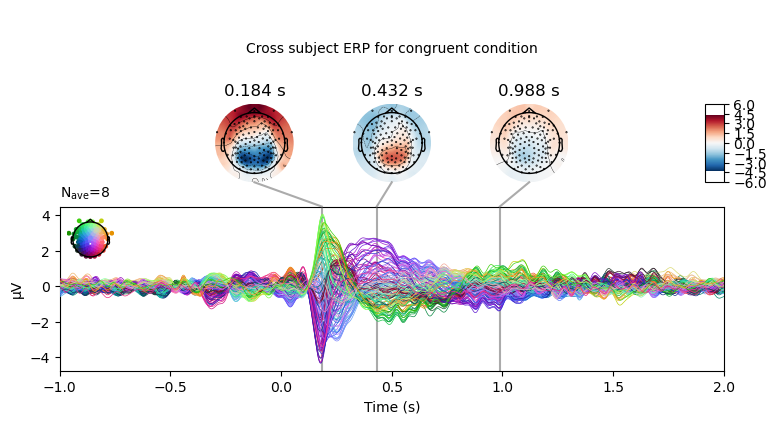

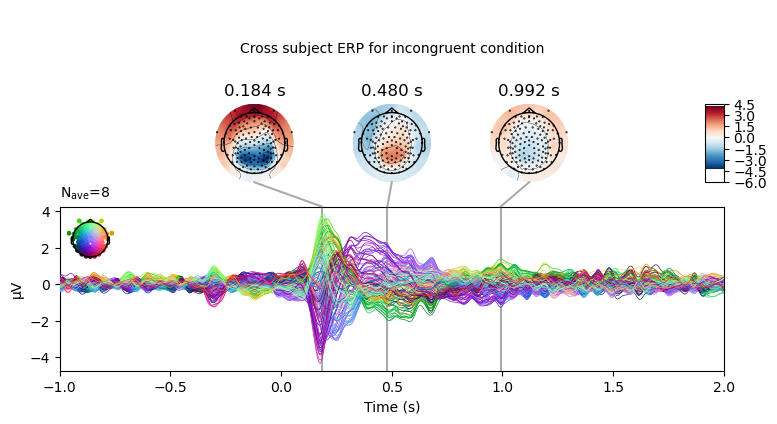

In [4]:
GA_congruent.plot_joint(title = 'Cross subject ERP for congruent condition', show=False)
GA_incongruent.plot_joint(title = 'Cross subject ERP for incongruent condition', show=False)
plt.show()

# Spatial filtering

## Spectro-Spatial Decomposition
Since we want to observe brain oscillation within specific frequency bands only, Spatio-Spectral decomposition seems to be the most appropriate spatial filtering.
Fitting SSD spatial filter for each subject would result into an overfitting across subject, that will maximize individually theta activity.

The hypothesis is that theta activity is a specific feature of executive attention, therefore we want to see the difference between congruent and incongruent using SSD filtering. In order to not overfit the filter, we will proceed as follow: 
* Consider 2 classes: congruent and incongruent
* Consider 2 populations: healthy control and TBI patients.

Since we have a healthy control population we will design the spatial filter based on their activity within theta band between the 2 classes. To do so we will train a classifier on the entire healthy population. One component of the model will be the SSD filter that fit the best for the entire healthy control population to discriminate the 2 classes within theta band.

To analyse theta band activity within TBI population, the SSD filter will be applied and we will be able to see the differences between healthy theta activity (congruent VS incongruent) from TBI.

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

epochs_data = np.concatenate(epochs,axis=0)
labels_data = np.concatenate(labelsAcrossSubj,axis=0)

scores = []
band = 'theta'


cv = sklearn.model_selection.ShuffleSplit(50, train_size=0.4, test_size=0.3, random_state=42)
cv_split = cv.split(epochs_data)

# Assemble a classifier
vectorizer = mne.decoding.Vectorizer()
lda = LinearDiscriminantAnalysis()
ssd = mne.decoding.SSD(n_components = 4,
                    info=epoch.info,
                    reg='oas',
                    rank='full',
                    filt_params_signal=dict(l_freq=freq_bands[band][0],
                                            h_freq=freq_bands[band][1],
                                            l_trans_bandwidth=1,
                                            h_trans_bandwidth=1),
                    filt_params_noise=dict(l_freq=freq_bands[band][0]-1,
                                            h_freq=freq_bands[band][1]+1,
                                            l_trans_bandwidth=1,
                                            h_trans_bandwidth=1))

# Use scikit-learn Pipeline with cross_val_score function
clf = sklearn.pipeline.Pipeline([('ssd', ssd), ('vectorizer',vectorizer), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data, labels_data, cv=cv, n_jobs=-1)

# Printing the results
class_balance = np.mean(labels_data == labels_data[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

save_object(ssd, r'D:\WCM_data_analysis\Theta_analysis\ssd_filters.pkl')
save_object(clf, r'D:\WCM_data_analysis\Theta_analysis\classifier.pkl')                                                        

Classification accuracy: 0.507228 / Chance level: 0.506322


Load the saved SSD filter and Visualization of the created 4 first SSD patterns

C:\Users\Sam19\AppData\Local\Temp\ipykernel_2536\2111342649.py:5: FutureWarning: The "title" parameter is deprecated and will be removed in version 1.3. Use "fig.suptitle()" instead.
  patterns_epochs.plot_topomap(units=dict(mag='A.U.'), time_format='',show=False,title='SSD generated patterns')


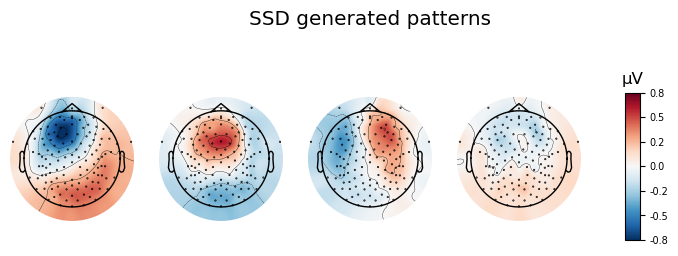

In [3]:
with open(r'D:\WCM_data_analysis\Theta_analysis\ssd_filter.pkl', 'rb') as inp:
    ssd = pickle.load(inp)
patterns_epochs = mne.EvokedArray(data=ssd.patterns_[:4].T,
                                 info=ssd.info)
patterns_epochs.plot_topomap(units=dict(mag='A.U.'), time_format='',show=False,title='SSD generated patterns')
plt.show()

# Event-related dynamics for theta frequency band
1. Load all epochs from all patients
2. Subtract the event related activity by subtracting the average across all epochs of each time points. Only pure oscillatory activity remains
3. filter epochs with pass band (theta band: 4 Hz to 7 Hz)
4. Perform a hilbert transform to obtain the envelope of the filtered signal -> The dynamic of the oscillatory activity within theta band

In other term this will give the Global Field Potential of the theta activity

In [4]:
AcrossSubjects = mne.concatenate_epochs(epochs)
trans_epochs = mne.EpochsArray(ssd.apply(AcrossSubjects.get_data()),events=AcrossSubjects.events, info = AcrossSubjects.info,tmin=-1,event_id=AcrossSubjects.event_id)


C:\Users\Sam19\AppData\Local\Temp\ipykernel_2536\3530545839.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  AcrossSubjects = mne.concatenate_epochs(epochs)


Not setting metadata
3039 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
3039 matching events found
No baseline correction applied
0 projection items activated


## Plot the dynamic of the theta activity for all subject for each conditions
Let's take a look on the spatial distribution of the theta activity as a function of the time:

Healthy control

Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 133644 out of 133644 | elapsed:   22.3s finished


Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 135837 out of 135837 | elapsed:   22.5s finished


Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


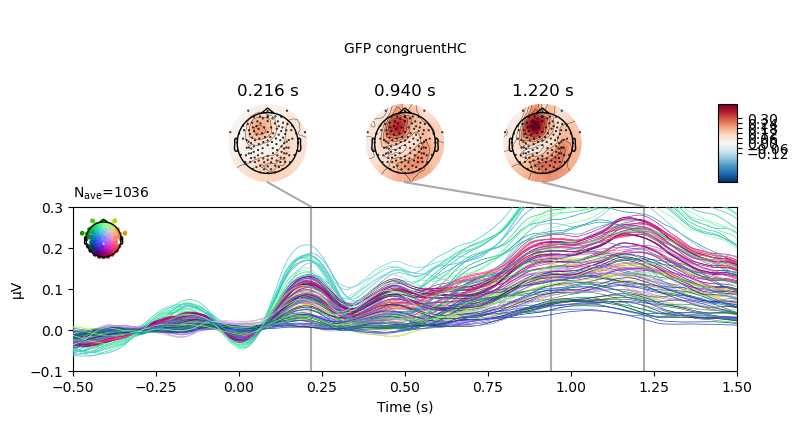

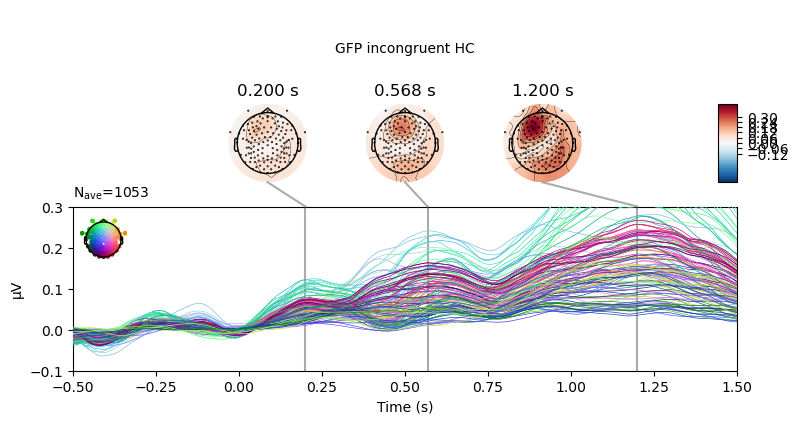

In [7]:
congruent_epo = trans_epochs['congruent'].copy().subtract_evoked().filter(l_freq=4,h_freq=7).apply_hilbert(envelope=True).apply_baseline(epoch_baseline).crop(tmin=-0.5,tmax=1.5)
congruent_evoked = congruent_epo.copy().average()
congruent_evoked.plot_joint(title='GFP congruent'  + FilesInfo['Subject'][0],show=False,ts_args={'ylim':{'eeg':[-0.1,0.3]}})
incongruent_epo = trans_epochs['incongruent'].copy().subtract_evoked().filter(l_freq=4,h_freq=7).apply_hilbert(envelope=True).apply_baseline(epoch_baseline).crop(tmin=-0.5,tmax=1.5)
incongruent_evoked = incongruent_epo.average()
incongruent_evoked.plot_joint(title='GFP incongruent ' + FilesInfo['Subject'][0],show=False,ts_args={'ylim':{'eeg':[-0.1,0.3]}})
plt.show()

Patients

Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 196080 out of 196080 | elapsed:   35.6s finished


Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
Subtracting Evoked from Epochs
[done]
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 195951 out of 195951 | elapsed:   34.2s finished


Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


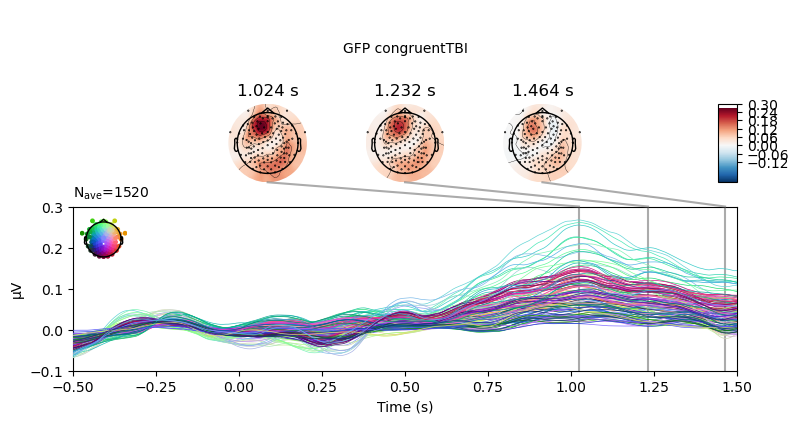

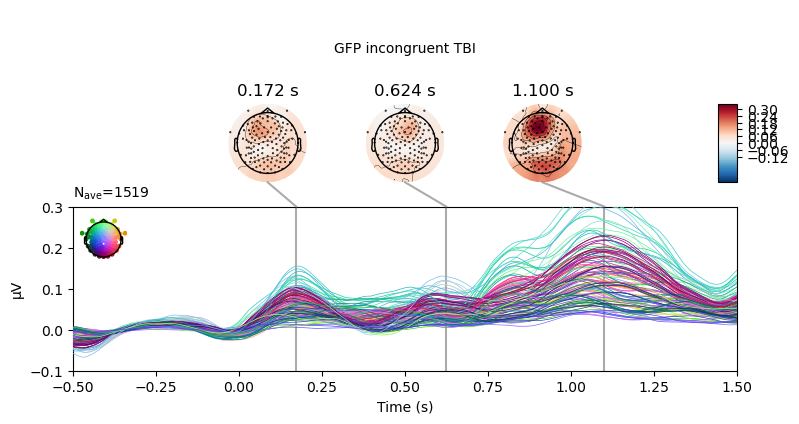

In [6]:
congruent_epo = trans_epochs['congruent'].copy().subtract_evoked().filter(l_freq=4,h_freq=7).apply_hilbert(envelope=True).apply_baseline(epoch_baseline).crop(tmin=-0.5,tmax=1.5)
congruent_evoked = congruent_epo.copy().average()
congruent_evoked.plot_joint(title='GFP congruent'  + FilesInfo['Subject'][0],show=False,ts_args={'ylim':{'eeg':[-0.1,0.3]}})
incongruent_epo = trans_epochs['incongruent'].copy().subtract_evoked().filter(l_freq=4,h_freq=7).apply_hilbert(envelope=True).apply_baseline(epoch_baseline).crop(tmin=-0.5,tmax=1.5)
incongruent_evoked = incongruent_epo.average()
incongruent_evoked.plot_joint(title='GFP incongruent ' + FilesInfo['Subject'][0],show=False,ts_args={'ylim':{'eeg':[-0.1,0.3]}})
plt.show()

We can notice that during congruent condition a burst of theta activity occurs right after the apparition of the target. Whereas the activity is more progressive as a function of the time for incongruent condition. We also can notice that the activity occurs on the frontal lobe which is consistant with the literature. So let's take a look at Fz especially between the two conditions.

combining channels using "mean"


C:\Users\Sam19\AppData\Local\Temp\ipykernel_12140\1201593096.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=['Fz'])


combining channels using "mean"


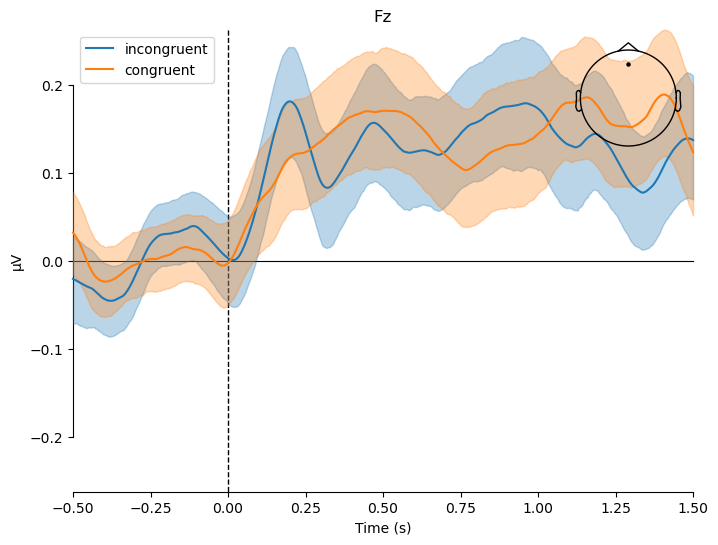

[<Figure size 800x600 with 2 Axes>]

In [104]:
evokeds = dict(incongruent=list(congruent_epo.iter_evoked()),
               congruent=list(incongruent_epo.iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=['Fz'])


Patients

combining channels using "mean"


C:\Users\Sam19\AppData\Local\Temp\ipykernel_2536\3743835106.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=['Fz'])


combining channels using "mean"


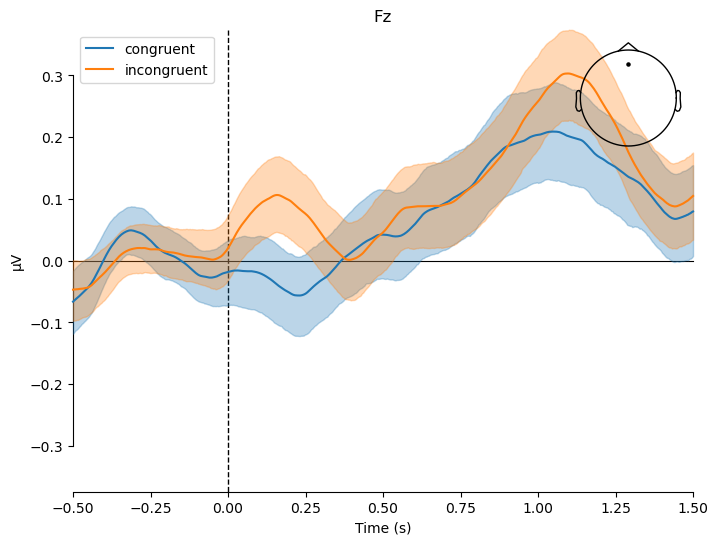

[<Figure size 800x600 with 2 Axes>]

In [10]:
evokeds = dict(congruent=list(congruent_epo.iter_evoked()),
               incongruent=list(incongruent_epo.iter_evoked()))
mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=['Fz'])

The difference between the two condition is not that obvious, but we can still observe a specific pattern for congruent condition. Compared to the patient population, the pattern is clearly different. These amplitudes will be studied within the cohort as a function of the subject's age.

## ERDS

Because we noticed midline frontal theta burst, now let's test it against the baseline to see if that burst is significant. To do so we will compute event related desyncrhonization/synchronization.

In [62]:
SavingNameEpochs = [FileInfo['Subject'] , '_' , FileInfo['Protocol'] , '_' , FileInfo['Subject_#'] , '_' , FileInfo['Visit'] , '-epo.fif']
epochs_with_evoked =  mne.read_epochs(os.sep.join([SavingPath,''.join(SavingNameEpochs)]),preload=True)
#incong_without_evoked = epochs_with_evoked['incongruent'].copy().subtract_evoked().apply_hilbert(envelope=True)
#cong_without_evoked = epochs_with_evoked['congruent'].copy().subtract_evoked().apply_hilbert(envelope=True)
#saving_fname_tfr = os.path.splitext(EEGfile)[0] + '-tfr.h5'
#mne.time_frequency.write_tfrs(saving_fname_tfr, tfr, overwrite=True)
#tfr = mne.time_frequency.read_tfrs(saving_fname_tfr, condition=None)

Reading C:\Users\Sam19\Desktop\WCM_data_analaysis\Temporary_folder_HC_analysis\HC_ATTN_001_S1-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
285 matching events found
No baseline correction applied
0 projection items activated
Subtracting Evoked from Epochs
[done]
Subtracting Evoked from Epochs
[done]


### ERDS HC

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  3.4min finished


Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.646303
stat_fun(H1): min=-38.803014 max=16.924927
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646303
stat_fun(H1): min=-38.803014 max=16.924927
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.646303
stat_fun(H1): min=-43.414778 max=21.257561
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646303
stat_fun(H1): min=-43.414778 max=21.257561
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.646303
stat_fun(H1): min=-44.233424 max=21.992705
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646303
stat_fun(H1): min=-44.233424 max=21.992705
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
2


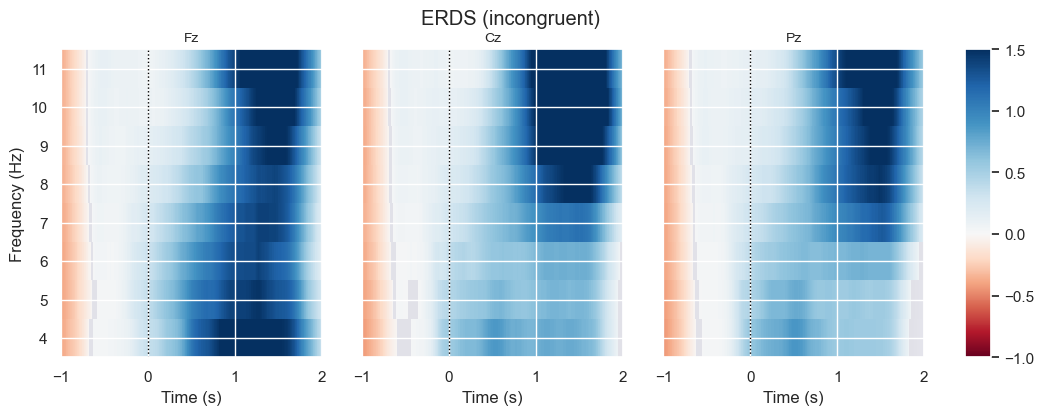

Using a threshold of 1.646327
stat_fun(H1): min=-40.863809 max=18.006749
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646327
stat_fun(H1): min=-40.863809 max=18.006749
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.646327
stat_fun(H1): min=-39.459760 max=20.493442
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646327
stat_fun(H1): min=-39.459760 max=20.493442
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.646327
stat_fun(H1): min=-49.465306 max=24.304973
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.646327
stat_fun(H1): min=-49.465306 max=24.304973
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
2


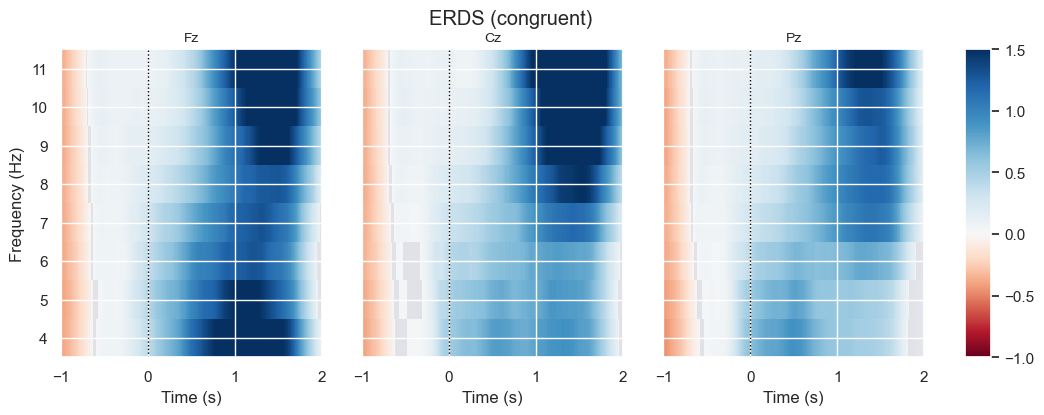

In [11]:
event_ids = ['incongruent','congruent'] #['FixationStart']
chan_names = ['Fz','Cz','Pz']
tmin, tmax = -1, 2
freqs = np.arange(4, 12)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = mt.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.01, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test  


tfr = mne.time_frequency.tfr_multitaper(AcrossSubjects, freqs=freqs, n_cycles=freqs, use_fft=True,
                    return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event].pick_channels(ch_names = chan_names)
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = mne.stats.permutation_cluster_1samp_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ =  mne.stats.permutation_cluster_1samp_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(chan_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        ax.set_xlim([-1,2])
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    print(ch)
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


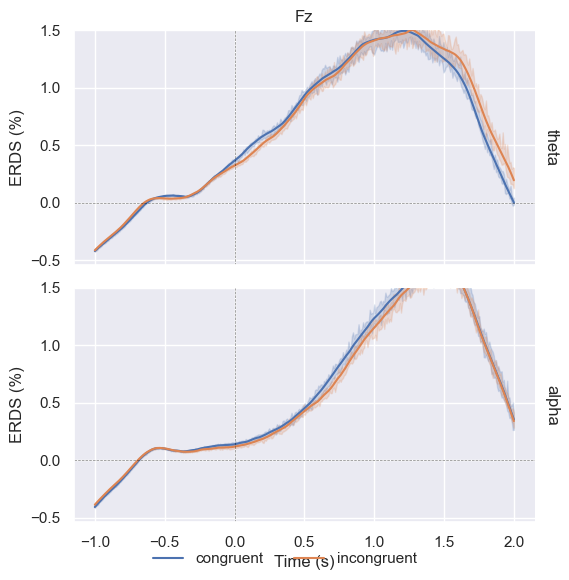

In [12]:
%matplotlib inline
import seaborn as sns
#del df
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
               
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:

df = df[df.channel.isin(electrodes)]
df = df[df.band.isin(freq_bands_of_interest)]

df['band'] = df['band'].cat.remove_unused_categories()
df['channel'] = df['channel'].cat.remove_unused_categories()


# Order channels for plotting:
"""df['channel'] = df['channel'].cat.reorder_categories(('Fz'),
                                                     ordered=True)"""

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

### ERDS TBI

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed:  5.2min finished


Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.645858
stat_fun(H1): min=-48.667252 max=20.952530
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645858
stat_fun(H1): min=-48.667252 max=20.952530
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645858
stat_fun(H1): min=-49.743628 max=22.217531
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645858
stat_fun(H1): min=-49.743628 max=22.217531
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645858
stat_fun(H1): min=-52.336106 max=23.312107
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645858
stat_fun(H1): min=-52.336106 max=23.312107
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
2


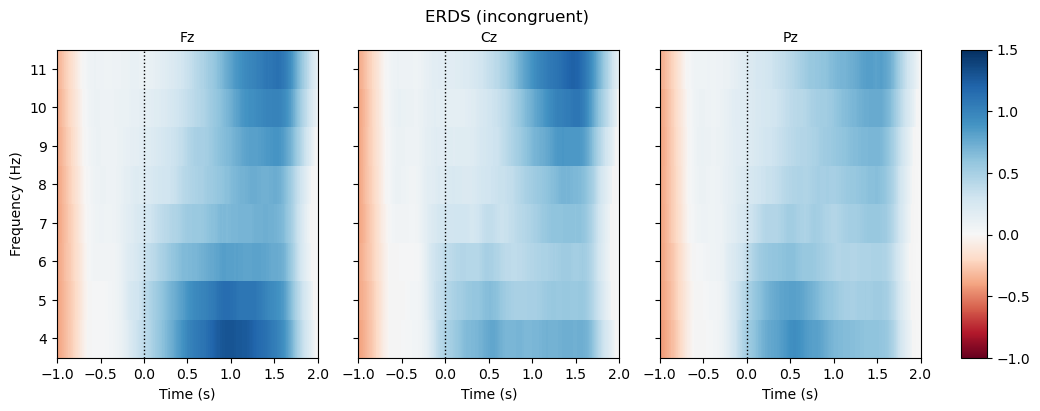

Using a threshold of 1.645857
stat_fun(H1): min=-51.152246 max=21.501247
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645857
stat_fun(H1): min=-51.152246 max=21.501247
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645857
stat_fun(H1): min=-48.472326 max=23.213640
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645857
stat_fun(H1): min=-48.472326 max=23.213640
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.645857
stat_fun(H1): min=-50.220578 max=23.138105
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.645857
stat_fun(H1): min=-50.220578 max=23.138105
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
2


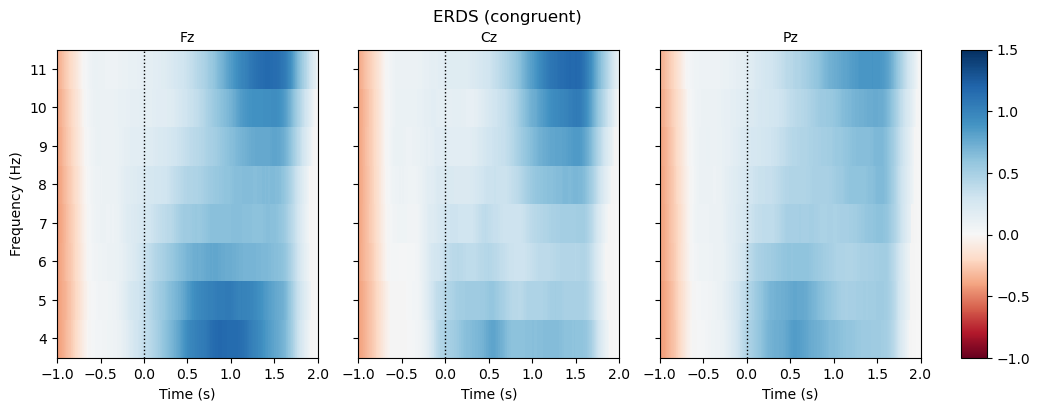

MemoryError: Unable to allocate 8.79 GiB for an array with shape (1179229248,) and data type object

In [8]:

event_ids = ['incongruent','congruent'] #['FixationStart']
chan_names = ['Fz','Cz','Pz']
tmin, tmax = -1, 2
freqs = np.arange(4, 12)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = mt.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.01, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test  


tfr = mne.time_frequency.tfr_multitaper(AcrossSubjects, freqs=freqs, n_cycles=freqs, use_fft=True,
                    return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event].pick_channels(ch_names = chan_names)
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = mne.stats.permutation_cluster_1samp_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ =  mne.stats.permutation_cluster_1samp_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(chan_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        ax.set_xlim([-1,2])
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    print(ch)
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()


In [11]:
epochs[0]

[<EpochsFIF |  285 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~210.8 MB, data loaded,
  'incongruent': 142
  'congruent': 143>,
 <EpochsFIF |  280 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~207.1 MB, data loaded,
  'incongruent': 139
  'congruent': 141>,
 <EpochsFIF |  265 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~196.0 MB, data loaded,
  'incongruent': 132
  'congruent': 133>,
 <EpochsFIF |  207 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~153.2 MB, data loaded,
  'incongruent': 105
  'congruent': 102>,
 <EpochsFIF |  267 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~197.5 MB, data loaded,
  'incongruent': 131
  'congruent': 136>,
 <EpochsFIF |  277 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~204.9 MB, data loaded,
  'incongruent': 138
  'congruent': 139>,
 <EpochsFIF |  278 events (all good), -1 - 2 sec, baseline -0.5 – 0 sec, ~205.7 MB, data loaded,
  'incongruent': 140
  'congruent': 138>,
 <EpochsFIF |  265 events (

## Age vs Amplitude plotting

In [17]:
%%capture
idx_age_sorted = sorted(range(len(age)), key=lambda k: age[k])
tmin = 0
tmax = 0.3
appended_df = list()
Dynamic_epochs = list()
channel = ['Fz']
participants = pd.read_csv(r'D:\WCM_data_analysis\Theta_analysis\participants.txt',sep='\t')
start = 0
age = list()
epochs = list()

for SelectedFile in range(start,len(EEG_name)):
    signalName = os.sep.join([SavingPath,''.join([EEG_name[SelectedFile], '.fif'])])
    age.append(int(participants['age'][participants['participant_id'].str.contains(FilesInfo['Subject'][SelectedFile]+FilesInfo['Subject_#'][SelectedFile])]))
    epochs.append(mne.read_epochs(signalName))

for i in range(len(epochs)):
     epoch = mne.EpochsArray(ssd.apply(epochs[i].get_data()),events=epochs[i].events, info = epochs[i].info,tmin=-1,event_id=epochs[i].event_id)
     Dynamic_epochs.append(epoch.pick_channels(channel).subtract_evoked().filter(l_freq=4,h_freq=7).apply_hilbert(envelope=True).apply_baseline(epoch_baseline).crop(tmin=-0.5,tmax=1.5))
     
for i in range(len(epochs)):
     d_iter = {'amplitude':np.concatenate(np.amax(Dynamic_epochs[idx_age_sorted[i]].get_data(tmin=tmin, tmax=tmax),axis=2)),
     'event':Dynamic_epochs[idx_age_sorted[i]].events[:, -1] - 2,
     'age': age[i]}
     df = pd.DataFrame(d_iter)
     appended_df.append(df)

Data = pd.concat(appended_df)

(-2e-06, 6e-06)

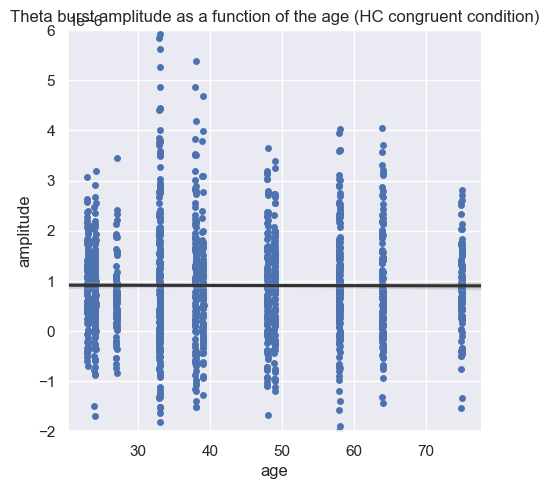

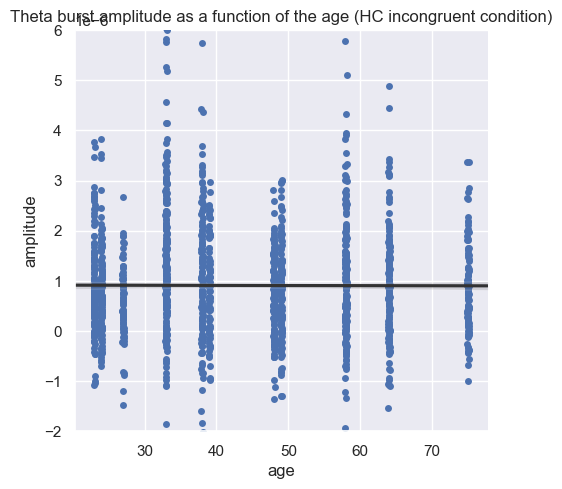

In [18]:
%matplotlib inline
import seaborn as sns
sns.set_theme()
fig = sns.catplot(
    data=Data.loc[Data['event']==1], x="age", y="amplitude",
    native_scale=True, zorder=1
).set(title='Theta burst amplitude as a function of the age (HC congruent condition)')
sns.regplot(
    data=Data, x="age", y="amplitude",
    scatter=False, truncate=False, order=1, color=".2",
)
plt.ylim(-2e-6,6e-6)
sns.catplot(
    data=Data.loc[Data['event']==2], x="age", y="amplitude",
    native_scale=True, zorder=1
).set(title='Theta burst amplitude as a function of the age (HC incongruent condition)')
sns.regplot(
    data=Data, x="age", y="amplitude",
    scatter=False, truncate=False, order=1, color=".2",
)
plt.ylim(-2e-6,6e-6)

(-2e-06, 6e-06)

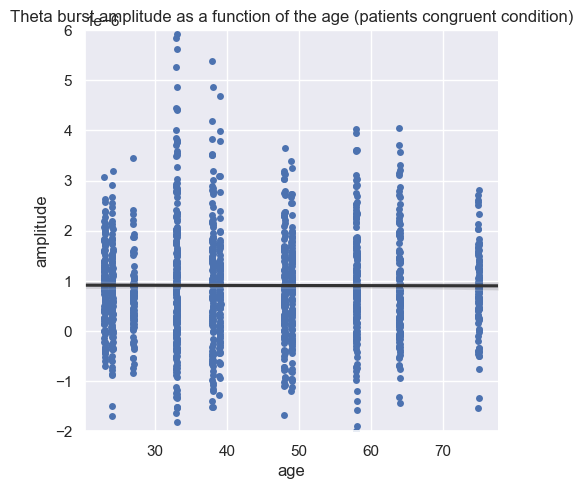

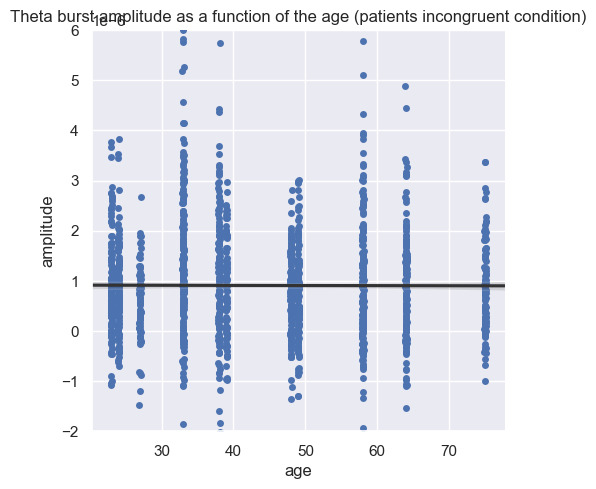

In [19]:
%matplotlib inline
import seaborn as sns

sns.catplot(
    data=Data.loc[Data['event']==1], x="age", y="amplitude",
    native_scale=True, zorder=1
).set(title='Theta burst amplitude as a function of the age (patients congruent condition)')
sns.regplot(
    data=Data, x="age", y="amplitude",
    scatter=False, truncate=False, order=1, color=".2",
)
plt.ylim(-2e-6,6e-6)
sns.catplot(
    data=Data.loc[Data['event']==2], x="age", y="amplitude",
    native_scale=True, zorder=1
).set(title='Theta burst amplitude as a function of the age (patients incongruent condition)')
sns.regplot(
    data=Data, x="age", y="amplitude",
    scatter=False, truncate=False, order=1, color=".2",
)
plt.ylim(-2e-6,6e-6)